# Imaginary time projection method
Target: Construct a code that numerically finds the ground state energy $E_0$ and the corresponding wave function $\psi_0$ of the Schrodinger equation 
\begin{equation}
\hat{H}\psi_0(x) = E_0\psi_0(x)
\end{equation}

Consider the following equation 
\begin{equation}
-\hbar\frac{\partial \varphi(x,\tau)}{\partial \tau} = \hat{H}\varphi(x,\tau).\label{eqn:imgt}
\end{equation}
Its formal solution is
\begin{equation}
\varphi(x,\tau) = e^{-\tau \hat{H}/\hbar}\varphi_0(x),\label{eqn:sol}
\end{equation}
where $\varphi_0(x)$ is an arbitrary initial wave function, which should be set by initial conditions. Assume for a moment that we know all solutions of our target equation, i.e.
\begin{equation}
\hat{H}\psi_n(x) = E_n\psi_n(x).
\end{equation}
The eigenstates $\psi_n$ of any hermitian operator constitute a basis, so any function can be written as
\begin{equation}
\varphi_0(x) = \sum_n c_n \psi_n(x),\label{eqn:expansion}
\end{equation}
where $c_n$ are expansion coefficients (their values will not be needed in practice). Then, we get
\begin{equation}
\varphi(x,\tau) = e^{-\tau \hat{H}/\hbar}\sum_n c_n \psi_n(x)=\sum_n c_ne^{-\tau \hat{H}/\hbar}\psi_n(x)=\sum_n c_ne^{-\tau E_n/\hbar}\psi_n(x).
\end{equation}
The eigenenergies are organized as follows: $E_0<E_1<E_2<...$, thus for large values of $\tau\rightarrow \infty$ we have $e^{-\tau E_0/\hbar}\gg e^{-\tau E_1/\hbar}\gg e^{-\tau E_2/\hbar}\gg ...$ and 
\begin{equation}
\varphi(x,\tau\rightarrow \infty)=c_0 e^{-\tau E_0/\hbar}\psi_0(x)=C_0\psi_0(x),
\end{equation}
where all contributions with $n>0$ were assumed to be negligible in comparison to $n=0$ contribution.
The remaining unknown coefficient $C_0$ can be obtained from the normalization condition.

Finally, the ground state energy can be found as
\begin{equation}
E_0 = \int \psi_0^*(x)\hat{H}\psi_0(x) dx 
\end{equation} 

# Implementation (one of the possibilities)
To make use of the imaginary time evolution method we need a prescription how to execute the operation $e^{-\tau \hat{H}/\hbar}\varphi_0(x)$. We can do it as follow (I provide the simplest prescription, there are also more efficient prescriptions)
\begin{equation}
\varphi(x,\tau)=e^{-\tau \hat{H}/\hbar}\varphi_0(x)=e^{-\Delta\tau \hat{H}/\hbar}e^{-\Delta\tau \hat{H}/\hbar}\ldots e^{-\Delta\tau \hat{H}/\hbar}\varphi_0(x),
\end{equation}
which means that we can apply the elementary operation $e^{-\Delta\tau \hat{H}/\hbar}$ in a loop, until the result converge to the ground state (in practice with some precision $\varepsilon$). If $\Delta\tau$ is sufficiently small we can use the Taylor expansion
\begin{equation}
e^{-\Delta\tau \hat{H}/\hbar}\varphi(x)\approx (1-\Delta\tau \hat{H}/\hbar)\varphi(x).
\label{eqn:singlestep}
\end{equation}
One can also use higher order expansion.

# Wave function representation

Next we need to represent the wave function. The function $\varphi(x)$ can be represented as an array of numbers $\varphi[k]$ of size $N$ where $\varphi[k]\equiv \varphi(x_0+ka)$ with $k=0,1,\ldots,N-1$. The $x$ domain spans interval $[x_0,x_0+a(N-1)]$, and $a$ is a space discretization step. 

The $x_0$, $a$ and $N$ will be the algorithm parameters, and one needs to select them in such a way to assure that the solution vanishes at the boundaries and at the same time the discretization is sufficient to resolve structures of the wave function. Then, the external potential is also represented as a vector $V(x)\rightarrow V[k]$. The operation $V(x)\varphi(x)$ is equivalent to element-by-element multiplication. Computation of derivatives can be executed either by using finite-difference formulas or by spectral methods.  

Integrals can be computed as follow (one can use more accurate formulas for integrals, like Simpson's quadrature)
\begin{equation}
\int \varphi(x)dx\approx \sum_{k=0}^{N-1} \varphi[k] a.
\end{equation}

# Computation of derivatives via spectral method
Spectral representation
\begin{equation}
f(x)=\frac{1}{2\pi}\int\tilde{f}(k)e^{ikx}dk
\end{equation}
Then
\begin{equation}
\frac{d^n}{dx^n}f(x)=\frac{1}{2\pi}\int(ik)^n\tilde{f}(k)e^{ikx}dk=\frac{1}{2\pi}\tilde{F}^{(n)}(k)e^{ikx}dk,
\end{equation}
Thus, the algorithm is:
1. Compute forward FT of f(x) to obtain f(k)
2. Construct $\tilde{F}^{(n)}(k)=(ik)^n\tilde{f}(k)$
3. Compute backward FT of $\tilde{F}^{(n)}(k)$ to obtain $\frac{d^n f(x)}{dx^n}$

# Simple GPE code

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# Constants
m=2.0     # mass of dimer (two particles) 
hbar=1.0  # h/2pi
N=100.0    # number of dimers
a_s=0.1   # scattering length
U0 = 4.*np.pi*hbar**2*a_s/m # Coupling constant - unregularized

# Domain - 2D lattice 
nx=32
ny=32
dx=1.0 # lattice spacing
dy=1.0 # lattice spacing

# make grid
x = np.arange(-dx*nx/2, dx*nx/2, dx) # domain - x coordinate
y = np.arange(-dy*ny/2, dy*ny/2, dy) # domain - y coordinate
xv, yv = np.meshgrid(x, y, indexing='ij')

In [3]:
# Computation of derivatives
kx = np.fft.fftfreq(nx, d=dx)*2.*np.pi         # domain - momentum space (x)
ky = np.fft.fftfreq(ny, d=dy)*2.*np.pi         # domain - momentum space (y)
kxv, kyv = np.meshgrid(kx, ky, indexing='ij')
k2v = kxv**2 + kyv**2                         # k^2 = kx^2 + ky^2

def laplace2d(f):
    f_k=np.fft.fft2(f)
    f_k = f_k*(-1.0)*k2v
    f_k = np.fft.ifft2(f_k)
    return f_k

def dfdx2d(f):
    f_k=np.fft.fft2(f)
    f_k = f_k*(1.0j)*kxv
    f_k = np.fft.ifft2(f_k)
    return f_k

def dfdy2d(f):
    f_k=np.fft.fft2(f)
    f_k = f_k*(1.0j)*kyv
    f_k = np.fft.ifft2(f_k)
    return f_k

In [4]:
# Function for making 2D plots
def plot2d(f):
    ratio=nx/ny
    scale=4.0
    fig, ax = plt.subplots(figsize=(scale*ratio,1.3*scale*ratio))

    im = ax.imshow(np.transpose(f), interpolation='bilinear', extent=[-nx/2*dx, (nx/2-1)*dx, -ny/2*dy, (ny/2-1)*dy], aspect='auto')
    fig.colorbar(im, ax=ax, orientation="horizontal")

    plt.tight_layout()
    plt.show()

In [5]:
# smooth step function - will be needed later
def smooth_from0to1(x):
    if x<=0.0: return 0.0
    if x>=1.0: return 1.0
    return 0.5*( 1.0+np.tanh( np.tan( 0.5*np.pi*( 2.0*x-1.0 ) ) ) )
def smooth_step(x, x1, x2):
    r=np.ones(x.shape)
    for ix in np.arange(nx):
        for iy in np.arange(ny):
            if x[ix,iy]<=x1:
                r[ix,iy]=1.0
            elif x[ix,iy]<=x2:
                r[ix,iy]=1.0-smooth_from0to1((x[ix,iy]-x1)/(x2-x1))
            else:
                r[ix,iy]=0.0
    return r
    
mask_fun=smooth_step(np.sqrt(xv**2+yv**2), 0.85*nx/2, 0.95*nx/2)
#plot2d(mask_fun)

In [6]:
# External potential
omega_x = 0.05
omega_y = 0.05
Vext = m*omega_x**2*xv**2/2 + m*omega_y**2*yv**2/2 # 2D harmonic potential
#plot2d(Vext)

In [7]:
# this function applies Hamitonian to the wave-function
def apply_H(psi, Vext, nonlinear_term):
    return (-1.0*hbar**2/(2.*m))*laplace2d(psi) + Vext*psi + nonlinear_term*psi

# # version with the rotating frame
# def apply_H(psi, Vext, nonlinear_term):
#     Omega=0.05
#     omLz = Omega*(xv*(-1.j*hbar*dfdy2d(psi)) -yv*(-1.j*hbar*dfdx2d(psi)))
#     omLz = omLz*mask_fun
#     return (-1.0*hbar**2/(2.*m))*laplace2d(psi) + Vext*psi + nonlinear_term*psi -omLz

In [8]:
# this function computes energy
def energy(psi):
    nonlin=U0*np.abs(psi)**2 # nonlinear term
    Hpsi=apply_H(psi,Vext,nonlin) # H*psi
    return np.real(np.sum(np.conj(psi)*Hpsi)*dx*dy)

In [9]:
# imaginary time evolution step
def img_step(dtau, psi):
    nonlin=U0*np.abs(psi)**2 # nonlinear term
    Hpsi=apply_H(psi,Vext,nonlin) # H*psi
    HHpsi=apply_H(Hpsi,Vext,nonlin) # H*H*psi
    HHHpsi=apply_H(HHpsi,Vext,nonlin) # H*H*H*psi
    return (psi -dtau*Hpsi/hbar +dtau**2*HHpsi/hbar**2/2. -dtau**3*HHHpsi/hbar**3/6.)

In [10]:
# normalize psi such that integral |psi|^2 dxdy = N
def normalize(psi):
    norm=np.sum(np.abs(psi)**2)*dx*dy
    return psi*np.sqrt(N/norm)

## Main code

In [16]:
# initial wave-function
# psi=normalize(np.ones([nx,ny]))
psi=normalize( np.random.random([nx,ny])+np.random.random([nx,ny])*1.j )

In [17]:
# compute initial value of the energy
Eold=energy(psi)
Enew=Eold

max_sweeps=1000
nsteps=100
dtau=0.01
eps=1.0e-6
for isweep in range(max_sweeps):
    # do imaginary time evolution for nsteps
    for istep in range(nsteps):
        psi=img_step(dtau, psi)
        psi=normalize(psi) # normalize after each step
        
    # check new energy
    Enew=energy(psi)
    print("%8d: E=%12.8f diff=%12.8f" % (isweep, Enew,np.abs(Enew-Eold)), end='\r')
    
    # break if energy change is smaller than the treshold
    if np.abs(Enew-Eold)<eps:
        break
    Eold=Enew

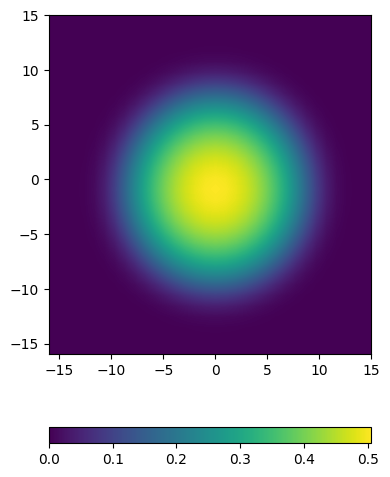

In [13]:
# plot density distribution
plot2d(np.abs(psi)**2)